In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import seaborn as sns

from kloppy import (
    metrica, wyscout
)

In [2]:
games = [2576322, 2576323, 2576324, 2576325, 2576326, 2576327, 2576328, 2576329, 2576330, 2576331, 2576333, 2576334, 2576335, 2576336, 2576337, 2576338, 2576290, 2576291, 2576292, 2576293, 2576294, 2576295, 2576296, 
         2576297, 2576298, 2576299, 2576300, 2576301, 2576302, 2576303, 2576304, 2576305, 2576306, 2576307, 2576308, 2576272, 2576273, 2576274, 2576275, 2576276, 2576277, 2576278, 2576279, 2576280, 2576282, 2576283, 
         2576284, 2576285, 2576286, 2576287, 2576288, 2576289, 2516893, 2516894, 2516895, 2516896, 2516897, 2516898, 2516899, 2516900, 2516901, 2516902, 2516903, 2516904, 2516905, 2516906, 2516907, 2516908, 2516909, 
         2516910, 2516911, 2516912, 2516873, 2516874, 2516875, 2516876, 2516877, 2516878, 2516879, 2516880, 2516881, 2516882, 2516883, 2516884, 2516885, 2516886, 2516887, 2516888, 2516889, 2516890, 2516891, 2516892,
         2516913, 2516914, 2516915, 2516916, 2516917, 2516918, 2516919, 2516920, 2516921, 2516922, 2516923, 2516924, 2516926, 2516927, 2516928, 2516929, 2516930, 2516931, 2516932]
np.unique(games).shape[0], len(games)


(111, 111)

In [3]:
def game_loader(matches):
    result = pd.DataFrame([])
    for i in matches:
        dataset = wyscout.load_open_data(match_id=i)
        game = dataset.to_df()
        temp_game = game.copy()
        temp_game.dropna(axis=1, how="all", inplace=True)
        temp_game = temp_game[["event_type", "coordinates_x", "coordinates_y", "end_coordinates_x", "end_coordinates_y"]]
        temp_game = temp_game[~(temp_game["event_type"] == "GENERIC:generic")]
        
        cols_with_nan = temp_game.columns[temp_game.isnull().any()]
        for col in cols_with_nan:
            idxs = temp_game[temp_game[col].isnull()].index
            if col.endswith("x"):
                temp_game.loc[idxs, col] = temp_game.loc[idxs, "coordinates_x"]
            elif col.endswith("y"):
                temp_game.loc[idxs, col] = temp_game.loc[idxs, "coordinates_y"]

        result = pd.concat([result, temp_game])
        
    return result

In [4]:
results = game_loader(games)

In [9]:
results

,event_type,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y
0,PASS,0.335873,0.388403,0.664127,0.085697
1,DUEL,0.335873,0.914303,0.335873,0.914303
2,DUEL,0.664127,0.085697,0.664127,0.085697
3,RECOVERY,0.767905,0.021424,0.767905,0.021424
4,PASS,0.203792,0.946440,0.373610,0.925015
...,...,...,...,...,...
1719,DUEL,0.934524,0.064272,0.934524,0.064272
1720,BALL_OUT,0.104762,1.000000,0.104762,1.000000
1721,FOUL_COMMITTED,0.122222,0.989288,0.122222,0.989288
1722,CARD,0.122222,0.989288,0.122222,0.989288


In [5]:
X, y = results.loc[:, "coordinates_x":], results["event_type"]

In [8]:
np.unique(y, return_counts=True)

(array(['BALL_OUT', 'CARD', 'CLEARANCE', 'DUEL', 'FOUL_COMMITTED',
        'GOALKEEPER', 'INTERCEPTION', 'MISCONTROL', 'PASS', 'RECOVERY',
        'SHOT'], dtype=object),
 array([  7923,    444,   3254,  51142,   3017,   1036,   9993,    728,
        107499,   7312,   2640], dtype=int64))

In [7]:
y.shape

(194988,)

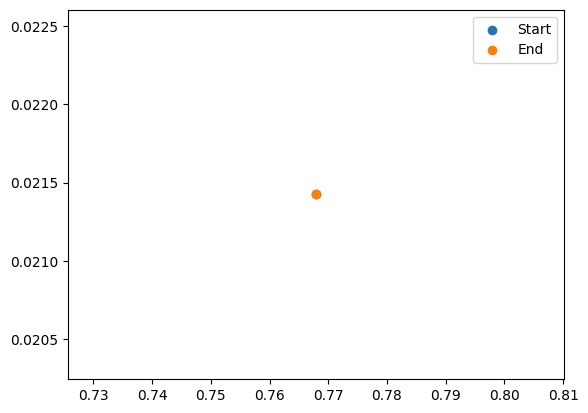

In [32]:
fig, ax = plt.subplots()

# Plot starting points
ax.scatter(temp["coordinates_x"], temp["coordinates_y"], label='Start')

# Plot ending points
ax.scatter(temp["end_coordinates_x"], temp["end_coordinates_y"], label='End')

# Draw lines connecting start to end points
for i in range(temp.index[0], len(temp)):
    ax.plot([temp["coordinates_x"][i], temp["end_coordinates_x"][i]], 
            [temp["coordinates_y"][i], temp["end_coordinates_y"][i]], 
            'gray', alpha=0.5)

ax.legend()
plt.show()

In [26]:
X.shape

(194988, 4)

In [27]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

assert X.shape[0] == y.shape[0]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, split, model_name=""):
    fig, ax = plt.subplots(figsize=(12, 10))

    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_normalized = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    annot = []
    for i in range(len(cm_counts)):
        row_annot = []
        for j in range(len(cm_counts[i])):
            row_annot.append(f"{cm_counts[i, j]}")# | {cm_normalized[i, j]:.2f}")
        annot.append(row_annot)
    
    sns.heatmap(cm_normalized, 
                annot=annot,
                fmt="", 
                cmap="viridis", 
                xticklabels=labels, 
                yticklabels=labels,
                cbar_kws={"label": "Normalized Frequency"})

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name.title()} Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)


    print(f"{model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"{model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   
    print(f"{model_name} testing precision: {precision * 100:0.2f}%")
    print(f"{model_name} testing recall: {recall * 100:0.2f}%")
    print(f"{model_name} testing f1: {f1 * 100:0.2f}%\n\n\n")

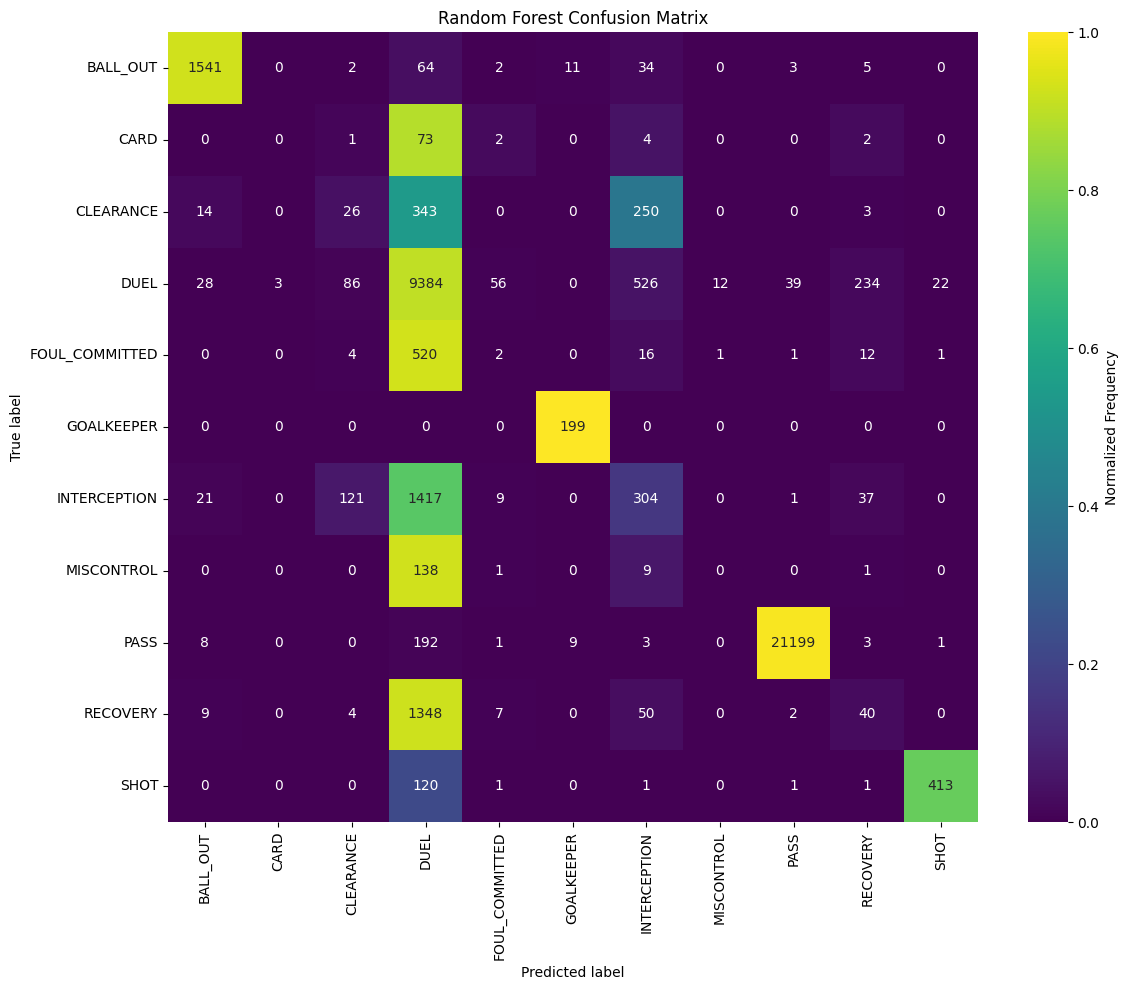

Random Forest training accuracy: 87.28%
Random Forest testing accuracy: 84.90%

Random Forest testing precision: 80.89%
Random Forest testing recall: 84.90%
Random Forest testing f1: 82.30%





In [30]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

labels = np.unique(y)
        
conf_matrix(y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_pred=y_test_pred, labels=labels, split=0, model_name="Random Forest")    

In [52]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf',), 'C':[2, 3, 4,5,6,7,8,9, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [53]:
clf.best_params_, clf.best_score_

({'C': 5, 'kernel': 'rbf'}, 0.9866666666666667)

In [4]:
col = list(a.columns[3:])
a.columns = ["Period", "Time [s]", "Frame"] + col
a["Time [s]"] = a["Time [s]"] / np.timedelta64(1, "s")

In [5]:
a

,Period,Time [s],Frame,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,1_x,...,44_x,44_y,44_d,44_s,44_mapping,45_x,45_y,45_d,45_s,45_mapping
0,1,0.04,1,None,None,NaN,NaN,None,None,0.68944,...,NaN,NaN,None,NaN,-100.0,0.91063,0.51413,None,2.61732,2.0
1,1,0.08,2,None,None,NaN,NaN,None,None,0.68923,...,NaN,NaN,None,NaN,-100.0,0.90999,0.51272,None,2.61732,2.0
2,1,0.12,3,None,None,NaN,NaN,None,None,0.68903,...,NaN,NaN,None,NaN,-100.0,0.90935,0.51132,None,2.61732,2.0
3,1,0.16,4,None,None,NaN,NaN,None,None,0.68884,...,NaN,NaN,None,NaN,-100.0,0.90871,0.50993,None,2.61732,2.0
4,1,0.20,5,None,None,NaN,NaN,None,None,0.68867,...,NaN,NaN,None,NaN,-100.0,0.90805,0.50856,None,2.61732,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162320,1,6492.84,162321,None,None,NaN,NaN,None,None,NaN,...,0.41793,0.87794,None,0.051278,0.0,0.85587,0.43931,None,NaN,-100.0
162321,1,6492.88,162322,None,None,NaN,NaN,None,None,NaN,...,0.41795,0.87796,None,0.047640,0.0,0.85587,0.43931,None,NaN,-100.0
162322,1,6492.92,162323,None,None,NaN,NaN,None,None,NaN,...,0.41796,0.87799,None,0.046902,0.0,0.85587,0.43931,None,NaN,-100.0
162323,1,6492.96,162324,None,None,NaN,NaN,None,None,NaN,...,0.41798,0.87801,None,0.047747,0.0,0.85587,0.43931,None,NaN,-100.0


In [21]:
_s = [col for col in a.columns if col.endswith("_s")]

In [27]:
drop_list = ["ball_owning_team_id", "ball_state", "ball_z", "ball_speed"]
columns_to_drop = drop_list + [col for col in a.columns if col.endswith("_mapping") or col.endswith("_d")]
a.drop(columns=columns_to_drop, inplace=True)

In [7]:
a[a.loc[:, "44_y"].isna()].index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       161240, 161241, 161242, 161243, 161244, 161245, 161246, 161247, 161248,
       161249],
      dtype='int64', length=160556)

In [28]:
a

,Period,Time [s],Frame,ball_x,ball_y,1_x,1_y,1_s,2_x,2_y,...,42_s,43_x,43_y,43_s,44_x,44_y,44_s,45_x,45_y,45_s
0,1,0.04,1,NaN,NaN,0.68944,1.02866,0.402215,0.45254,0.65863,...,0.958435,NaN,NaN,NaN,NaN,NaN,NaN,0.91063,0.51413,2.61732
1,1,0.08,2,NaN,NaN,0.68923,1.02838,0.402215,0.45199,0.65776,...,0.958435,NaN,NaN,NaN,NaN,NaN,NaN,0.90999,0.51272,2.61732
2,1,0.12,3,NaN,NaN,0.68903,1.02810,0.402215,0.45144,0.65688,...,0.958435,NaN,NaN,NaN,NaN,NaN,NaN,0.90935,0.51132,2.61732
3,1,0.16,4,NaN,NaN,0.68884,1.02784,0.402215,0.45091,0.65600,...,0.958435,NaN,NaN,NaN,NaN,NaN,NaN,0.90871,0.50993,2.61732
4,1,0.20,5,NaN,NaN,0.68867,1.02758,0.402215,0.45039,0.65511,...,0.958435,NaN,NaN,NaN,NaN,NaN,NaN,0.90805,0.50856,2.61732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162320,1,6492.84,162321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.41793,0.87794,0.051278,0.85587,0.43931,NaN
162321,1,6492.88,162322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.41795,0.87796,0.047640,0.85587,0.43931,NaN
162322,1,6492.92,162323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.41796,0.87799,0.046902,0.85587,0.43931,NaN
162323,1,6492.96,162324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.41798,0.87801,0.047747,0.85587,0.43931,NaN


In [ ]:
with open('structured_data.json', 'r') as f:
    data = json.load(f)

In [23]:
df = metrica.load_tracking_epts(
    meta_data="data/Sample_Game_3/Sample_Game_3_metadata.xml",
    raw_data="data/Sample_Game_3/Sample_Game_3_tracking.txt",
    coordinates="metrica"
)

In [24]:
b = df.to_df()

In [8]:
b.columns

NameError: name 'b' is not defined

In [9]:
b

NameError: name 'b' is not defined

In [26]:
event = metrica.load_event(
    event_data="data/Sample_Game_3/Sample_Game_3_events.json",
    meta_data="data/Sample_Game_3/Sample_Game_3_metadata.xml",
).to_df()

In [31]:
event

,event_id,event_type,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,set_piece_type,body_part_type
0,2,PASS,COMPLETE,True,1,0 days 00:00:14.400000,0 days 00:00:15.040000,alive,FIFATMA,FIFATMA,P3577,0.50125,0.48725,0.49864,0.48705,P3574,KICK_OFF,None
1,3,CARRY,COMPLETE,True,1,0 days 00:00:15.040000,0 days 00:00:15.320000,alive,FIFATMA,FIFATMA,P3574,0.49864,0.48705,0.49700,0.48500,None,None,None
2,4,PASS,COMPLETE,True,1,0 days 00:00:15.320000,0 days 00:00:17,alive,FIFATMA,FIFATMA,P3574,0.49700,0.48500,0.63373,0.63449,P3575,None,None
3,5,CARRY,COMPLETE,True,1,0 days 00:00:17,0 days 00:00:18.560000,alive,FIFATMA,FIFATMA,P3575,0.63373,0.63449,0.66986,0.59707,None,None,None
4,6,PASS,COMPLETE,True,1,0 days 00:00:18.560000,0 days 00:00:20.240000,alive,FIFATMA,FIFATMA,P3575,0.66986,0.59707,0.80602,0.39821,P3569,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589,3616,PASS,COMPLETE,True,2,0 days 00:49:09.760000,0 days 00:49:12.280000,alive,FIFATMB,FIFATMB,P3698,0.73416,0.40874,0.71353,0.85950,P3587,None,None
3590,3617,PASS,COMPLETE,True,2,0 days 00:49:12.280000,0 days 00:49:14.800000,alive,FIFATMB,FIFATMB,P3587,0.71353,0.85950,0.88776,0.51189,P3595,None,None
3591,3618,CARRY,COMPLETE,True,2,0 days 00:49:12.280000,0 days 00:49:12.320000,alive,FIFATMB,FIFATMB,P3587,0.71353,0.85950,0.71353,0.85950,None,None,None
3592,3619,CARRY,COMPLETE,True,2,0 days 00:49:14.800000,0 days 00:49:15.640000,alive,FIFATMB,FIFATMB,P3595,0.88776,0.51189,0.89225,0.50456,None,None,None


In [32]:
from kloppy import skillcorner

In [68]:
skill = skillcorner.load(
    meta_data="match_data.json",
    raw_data="structured_data.json",
    include_empty_frames=False,
    coordinates="metrica"
).to_df()

In [70]:
skill

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,7638_x,...,away_anon_10663_d,away_anon_10663_s,away_anon_10674_x,away_anon_10674_y,away_anon_10674_d,away_anon_10674_s,away_anon_10673_x,away_anon_10673_y,away_anon_10673_d,away_anon_10673_s
0,1,0 days 00:00:00,1833,None,NaN,NaN,NaN,NaN,None,0.286359,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0 days 00:00:00.100000,1834,None,NaN,NaN,NaN,NaN,None,0.287093,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0 days 00:00:00.200000,1835,None,NaN,NaN,NaN,NaN,None,0.287707,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0 days 00:00:00.300000,1836,None,NaN,NaN,NaN,NaN,None,0.288795,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0 days 00:00:00.400000,1837,None,NaN,NaN,NaN,NaN,None,0.289064,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34014,2,0 days 00:49:54.200000,72103,None,139.0,0.936581,-0.020465,0.063876,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
34015,2,0 days 00:49:54.300000,72104,None,139.0,0.941653,-0.024549,0.039067,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
34016,2,0 days 00:49:54.400000,72105,None,139.0,0.946676,-0.028225,0.018283,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
34017,2,0 days 00:49:54.500000,72106,None,139.0,0.951649,-0.031491,0.001524,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


In [6]:
import json
import pickle

In [7]:
data_file = "test_data.pkl"

In [8]:
with open(data_file, 'rb') as f:
    data = pickle.load(f)

In [17]:
total = 0
for k, v in data.items():
    print(v.shape)
    total += v.shape[0]
print(total)

(127, 46)
(318, 46)
(89, 46)
534
